In [1]:
%run ../scripts/notebook_settings.py
import sgkit as sg
import xarray as xr
import glob

Reading in mutation/generation time estimates from Kuderna. I will assume that chromosome X has 80 % of the mutation rate of autosomes, corresponding to a 4:1 male bias in mutations.

In [2]:
# Mutation rate percentage calc.
(4*1/3+1*2/3)/(4*1/2+1*1/2)

# Even if females have no mutations, it's only 2/3
# (4*1/3+0*2/3)/(4*1/2+0*1/2)

0.8

In [3]:
kuderna_data = pd.read_csv("../data/science.abn7829_data_s2.csv")

In [4]:
# I pick out the following columns
col_species_mut = ['SPECIES_BINOMIAL', 'GENUS', 'SPECIES', 'FAMILY', 'GENERATION_LENGTH', 'MU_PER_GENERATION',
       'MU_PER_YEAR', 'EFFECTIVE_POP_SIZE']
df_species_mut = kuderna_data[col_species_mut]

<Axes: xlabel='MU_PER_YEAR', ylabel='Count'>

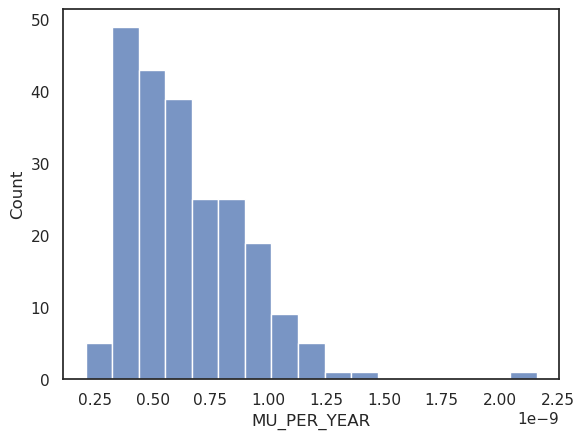

In [5]:
sns.histplot(kuderna_data[col_species_mut].MU_PER_YEAR)

<Axes: xlabel='GENERATION_LENGTH', ylabel='Count'>

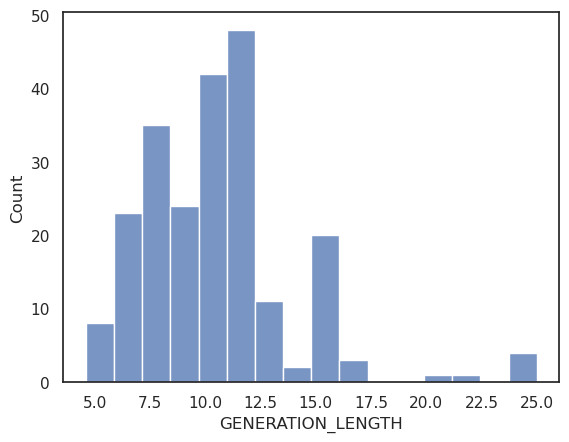

In [6]:
sns.histplot(kuderna_data[col_species_mut].GENERATION_LENGTH)

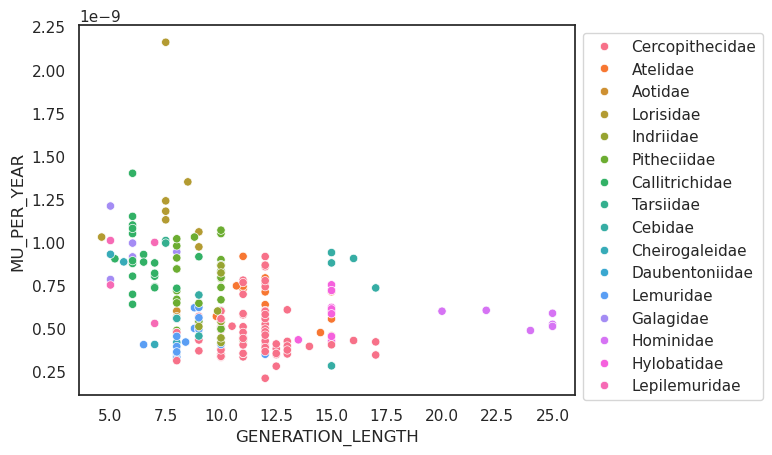

In [7]:
g = sns.scatterplot(data=kuderna_data, x="GENERATION_LENGTH", y="MU_PER_YEAR", hue="FAMILY")
plt.legend(bbox_to_anchor=(1.0, 1))

In [8]:
metadata_dir = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"


metadata_dirs = glob.glob(metadata_dir+"*_individuals.txt")

df_l = []
for d in metadata_dirs:
    # Identify IDs
    dir_metadata = pd.read_csv(d, sep="\t")
    df_l.append(dir_metadata)
all_inds = pd.concat(df_l)

In [9]:
all_inds.loc[all_inds.GVCF_ID == "PD_0629"]

,BIOSAMPLE_ID,PDGP_ID,GVCF_ID,SRA_SAMPLE_ID,BIOPROJECT_ID,BAM_FOLDER,GVCF_FOLDER,REFERENCE_FOLDER,GENUS,SPECIES,SUBSPECIES,REPORTED_SEX,GENETIC_SEX,AVG_COVERAGE_A,PROP_COVERED_A,AVG_COVERAGE_X,PROP_COVERED_X,AVG_COVERAGE_Y,PROP_COVERED_Y
0,SAMEA112483158,PD_0629,PD_0629,ERS14600509,PRJEB59576,Carlito_syrichta_ssp,Carlito_syrichta_ssp,Cephalopachus_bancanus_ssp,Carlito,syrichta,ssp,Unknown,Unknown,26.723,0.979,Unknown,Unknown,Unknown,Unknown


In [10]:
df_species_mut.loc[df_species_mut.GENUS == "Carlito"]

,SPECIES_BINOMIAL,GENUS,SPECIES,FAMILY,GENERATION_LENGTH,MU_PER_GENERATION,MU_PER_YEAR,EFFECTIVE_POP_SIZE
32,Carlito_syrichta,Carlito,syrichta,Tarsiidae,7.5,7.580000e-09,1.010000e-09,74616


In [15]:
starting_dir = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024/"
metadata_dir = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"
size_cutoff = 10000000
metadata_dirs = glob.glob(metadata_dir+"*_individuals.txt")
hetsep_dir = "steps/multihetsep"
cobraa_dir = "steps/cobraa"

c_list, x_list = [], []
for d in metadata_dirs:
    # Identify IDs
    dir_metadata = pd.read_csv(d, sep="\t")
    dir_metadata["gss"] = dir_metadata.GENUS+"_"+dir_metadata.SPECIES+"_"+dir_metadata.SUBSPECIES
    # Slightly hacky way of preferring females and those with high coverage.
    short_species = d.split("/")[-1].split("_")[0]
    female_df = dir_metadata[pd.to_numeric(dir_metadata['AVG_COVERAGE_X'], errors='coerce').notnull()]
    female_df = female_df.loc[(female_df.GENETIC_SEX == "F") & (female_df.AVG_COVERAGE_A >= 10)].sort_values(by="AVG_COVERAGE_A", ascending=False)
    male_df = dir_metadata[pd.to_numeric(dir_metadata['AVG_COVERAGE_A'], errors='coerce').notnull()]
    male_df = male_df.loc[~(male_df.GVCF_ID.isin(female_df.GVCF_ID)) & (male_df.AVG_COVERAGE_A >= 10)].sort_values(by="AVG_COVERAGE_A", ascending=False)
    sorted_df = pd.concat([female_df, male_df])
    if len(sorted_df) > 0:
        sorted_input = sorted_df
    else:
        print("No usable ind for", short_species)
        continue
    region_metadata = pd.read_csv(metadata_dir+short_species+"_regions_and_batches.txt",
                           sep="\t")
    # Go through every unique genotype calling set.
    for gvcf_folder in sorted_input.GVCF_FOLDER.unique():
        # print(gvcf_folder)
        # Pick the (currently one) best individuals in the metadata.
        picked_inds = sorted_input.loc[sorted_input.GVCF_FOLDER == gvcf_folder].GVCF_ID.iloc[:1]
        inds_cobraa = []
        # Choose all paths based on the regions file.
        batch_name = "{}/filteredVCF/bcf_step1/{}_batch{}_fploidy2_mploidy{}.bcf"
        gvcfs_names = starting_dir+batch_name
        mask_names = starting_dir+"{}/filteredVCF/pos_bed_cov_based/{}_batch{}_fploidy2_mploidy{}.bed"
        multihetsep_args = []
        # Workflow selecting all autosomal chromosomes above 1Mb in size.
        aut_and_x = region_metadata.loc[(region_metadata.FEMALE_PLOIDY == 2) &
                                     (region_metadata.END >= size_cutoff)]
        # print(aut_and_x)
        for c in aut_and_x.CONTIG_ID.unique()[:1]:
            # Batches are either aut/Y-linked or X-linked.
            mploidy = aut_and_x.loc[aut_and_x.CONTIG_ID == c].MALE_PLOIDY.iloc[0]
            b = aut_and_x.loc[aut_and_x.CONTIG_ID == c].BATCH.iloc[0]
            for i in picked_inds:
                if os.path.exists(gvcfs_names.format(gvcf_folder, gvcf_folder, b, mploidy)):
                    os.makedirs(hetsep_dir+"/"+i, exist_ok=True)
                    ind_dir = {}
                    ind_dir["refname"] = i
                    ind_dir["vcf"] = gvcfs_names.format(gvcf_folder, gvcf_folder, b, mploidy)
                    ind_dir["contig"] = c
                    ind_dir["mask"] = mask_names.format(gvcf_folder, gvcf_folder, b, mploidy)
                    ind_dir["callability"] = mask_names.format(gvcf_folder, gvcf_folder, b, mploidy)
                    multihetsep_args.append(ind_dir)
                    inds_cobraa.append(i)
                else:
                    print(gvcfs_names.format(gvcf_folder, gvcf_folder, b, mploidy), "does not exist")
        # print(multihetsep_args)
        hetsep_l = []
        for i in inds_cobraa:
            os.makedirs(cobraa_dir+"/"+i, exist_ok=True)
            # Aut run
            for c in aut_and_x.CONTIG_ID.unique()[:1]:
                c_list.append("steps/multihetsep/{}/{}.txt".format(i, c))
                hetsep_l.append({"multihetsep_l": ["steps/multihetsep/{}/{}.txt".format(i, c)],
                "chrom": c})

/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024/Pithecia_pissinatti_ssp/filteredVCF/bcf_step1/Pithecia_pissinatti_ssp_batch0_fploidy2_mploidy2.bcf does not exist


In [16]:
c_list

['steps/multihetsep/PD_0629/JAPVLO010000001.1.txt',
 'steps/multihetsep/SAMN23530509/NC_044976.1.txt',
 'steps/multihetsep/PD_0522/CM104434.1.txt',
 'steps/multihetsep/SAMN43386187/CM104434.1.txt',
 'steps/multihetsep/SAMN23530506/HiC_scaffold_1.txt',
 'steps/multihetsep/PD_0156/HiC_scaffold_1.txt',
 'steps/multihetsep/PD_0122/CM063169.1.txt',
 'steps/multihetsep/PD_0121/CM063169.1.txt',
 'steps/multihetsep/PD_0119/CM063169.1.txt',
 'steps/multihetsep/PD_0174/CM063169.1.txt',
 'steps/multihetsep/PD_0120/CM063169.1.txt',
 'steps/multihetsep/PD_0009/CM063169.1.txt',
 'steps/multihetsep/PD_0351/CM063169.1.txt',
 'steps/multihetsep/PD_0346/CM063169.1.txt',
 'steps/multihetsep/SAMEA112483168/NC_044976.1.txt',
 'steps/multihetsep/SAMEA112483237/NC_044976.1.txt',
 'steps/multihetsep/SAMN43494766/NC_044976.1.txt',
 'steps/multihetsep/SAMEA112483227/NC_044976.1.txt',
 'steps/multihetsep/SAMEA112483030/NC_044976.1.txt',
 'steps/multihetsep/SAMEA112483162/NC_044976.1.txt',
 'steps/multihetsep/PD_

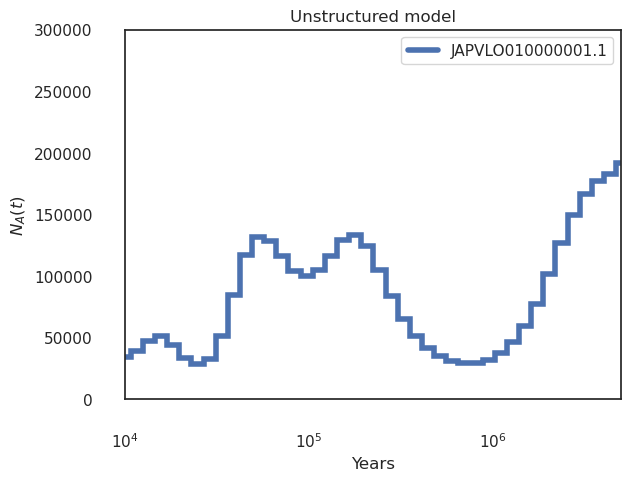

In [13]:
mu = 7.580000e-09
gen = 7.5
for p in ["../steps/cobraa/PD_0629/JAPVLO010000001.1_final_parameters.txt"]:
    label_tag = p.split("/")[-1].split("_")[0]
    final_params_file = p
    final_params = np.loadtxt(final_params_file)
    time_array = list(final_params[:,1])
    time_array.insert(0,0)
    time_array = np.array(time_array)
    plt.stairs(edges=(time_array/mu)*gen,values=(1/final_params[:,2])/mu,label=label_tag,linewidth=4,linestyle="solid",baseline=None)
    plt.xlim(1e+04,5e+06)
    plt.ylim(0,30e+04)
    plt.xscale('log')
    plt.ylabel('$N_A(t)$')
    plt.xlabel('Years')
    plt.tick_params(which='major',length=20)
    plt.tick_params(which='minor',length=10)
    plt.legend(ncol=2)
    plt.title('Unstructured model')
plt.show()